# The Boolean Pandemic
## Who is more likely to survive to the boolean pandemic?

# Overview
On January 1st, 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%.
While the conditions of the transmission of the virus is still unknown and there are no certainties of what leads a patient to survive or not to the virus, it seems there are some groups of people more prone to survive than others.
In this challenge, your goal is to build a **predictive model that answers the question “What are the people more likely to survive to the boolean pandemic?”** using the small quantity of data accessible of the patients – name, birthday date, severity of the disease, money of expenses associated to the treatment of each family, city and others.
As data scientists, your team is asked to analyze and transform as needed the data available and apply different models in order to answer in the more accurate way the defined question. Are you able to design a model that can **predict if a patient will survive, or not**, to the boolean pandemic?

# Objective
The goal of your team is to predict if a patient is going to survive, or not, on the test set by using the model you created on the training set. The score of your predictions is the percentage of instances you correctly predict, using the **accuracy**. You are allowed to apply any kind of classifier!

# Evaluation
The project will be evaluated taking into account the following criteria:
- Model accuracy;
- The quality of the data exploration, pre-processing, modelling and assessment steps;
- Contributions based on self-study and creativity will be valued;
- The notebook structure and the conclusions / insights / review / justification of techniques of the developed processes in each of the stages of the process. For example, after the data exploration phase, you should write down at the end of this topic in markdown the main insights that you gather from the data during this phase.

# Deliverables
You should submit a csv file with the number of instances in the test set, containing the columns [Patient_ID, Deceased], and only those columns. The Deceased column should contain the prediction (“0” or “1”). Your last solution (the Jupiter notebook) should be submitted on Moodle.

# Metadata (corrected)
- *Patient_ID* - The unique identifier of the patient
- *Family_Case_ID* - The family identification
- *Severity* - The severity of the disease, where 1 is the lowest and 3 the highest severity
- *Name* - The name of the patient
- *Birthday_year* - The year of birthday of the patient
- *Parents_Children_Infected* - The number of parents and/or children infected
- *Partner_Siblings_Infected* - The number of partner and/or siblings infected
- *Medical_Expenses_Family* - The medical expenses associated to try to contain the epidemy on the family
- *Medical_Tent* - The medical tent where the patient is / was lodged
- *City* - The original city of the patient
- *Deceased* - Flag if the patient deceased or not with the virus (0 = No, 1 = Yes)

# Import Packages and Data

In [45]:
import zipfile as zp
from math import ceil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
df_list = []
for file in ["train.csv", "test.csv"]:
    with zp.ZipFile("./data.zip") as myzip:
        with myzip.open(file) as myfile:
            df_list.append(pd.read_csv(myfile))
            
train_df, test_df = df_list

# Data Assessment

In [47]:
train_df.shape, test_df.shape

((900, 11), (400, 10))

In [48]:
train_df.rename({"Parents or siblings infected": "Parents_Children_Infected", "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)
test_df.rename({"Parents or siblings infected": "Parents_Children_Infected", "Wife/Husband or children infected": "Partner_Siblings_Infected"}, axis=1, inplace=True)

In [49]:
train_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
0,1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1
1,2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0
2,3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1
3,4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1
4,5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0


In [50]:
test_df.head()

,Patient_ID,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City
0,901,49242,3,Mr. Jody Pedro,NaN,0,0,203,NaN,Santa Fe
1,902,10400,3,Mr. Kevin Brent,1988.0,0,0,631,NaN,Santa Fe
2,903,10795,3,Mr. Frankie Cary,1981.0,1,0,376,NaN,Albuquerque
3,904,62440,3,Mr. Rick Pete,NaN,0,1,405,NaN,Albuquerque
4,905,81311,2,Mr. Matthew Erick,1996.0,0,0,378,NaN,Santa Fe


### Duplicates
No duplicates

In [51]:
# Check duplicates with all columns
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [52]:
# Check duplicates excluding Patient_ID
train_df.duplicated(subset=train_df.columns[1:]).sum(), test_df.duplicated(subset=test_df.columns[1:]).sum()

(0, 0)

In [53]:
# Check duplicates excluding Patient_id and Family_Case_ID
train_df.duplicated(subset=train_df.columns[2:]).sum(), test_df.duplicated(subset=test_df.columns[2:]).sum()

(0, 0)

In [54]:
# Check duplicates excluding Patient_id and Family_Case_ID and City
train_df.duplicated(subset=train_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum(),\
test_df.duplicated(subset=test_df.columns.drop(["Patient_ID", "Family_Case_ID", "City"])).sum()

(0, 0)

### Index and Data Types

In [55]:
train_df.set_index("Patient_ID", inplace=True)
test_df.set_index("Patient_ID", inplace=True)

In [56]:
train_df.dtypes

Family_Case_ID                 int64
Severity                       int64
Name                          object
Birthday_year                float64
Parents_Children_Infected      int64
Partner_Siblings_Infected      int64
Medical_Expenses_Family        int64
Medical_Tent                  object
City                          object
Deceased                       int64
dtype: object

### Numerical Statistics

In [57]:
descriptive = train_df.describe().T
descriptive['nulls'] = train_df.shape[0] - descriptive['count']
descriptive

,count,mean,std,min,25%,50%,75%,max,nulls
Family_Case_ID,900.0,14305.827778,25418.153900,345.0,8203.0,13593.5,18906.50,742836.0,0.0
Severity,900.0,2.313333,0.834223,1.0,2.0,3.0,3.00,3.0,0.0
Birthday_year,723.0,1990.266943,14.523335,1940.0,1982.0,1992.0,1999.50,2019.0,177.0
Parents_Children_Infected,900.0,0.380000,0.803247,0.0,0.0,0.0,0.00,6.0,0.0
Partner_Siblings_Infected,900.0,0.521111,1.098385,0.0,0.0,0.0,1.00,8.0,0.0
Medical_Expenses_Family,900.0,895.743333,1385.829926,0.0,221.0,405.0,861.25,14345.0,0.0
Deceased,900.0,0.614444,0.486997,0.0,0.0,1.0,1.00,1.0,0.0


**Insights:** 
- Outliers: Medical_Expenses_Family
- Transform Birthday_year in Age

### Categorical Statistics

In [58]:
descriptive = train_df[['Name','Medical_Tent', 'City']].describe().T
descriptive['nulls'] = train_df[['Name','Medical_Tent', 'City']].shape[0] - descriptive['count']
descriptive

,count,unique,top,freq,nulls
Name,900,899,Mr. Samuel Darnell,2,0
Medical_Tent,198,8,C,57,702
City,898,3,Santa Fe,649,2


**Insights:** Name might not seem valueable, however we can analyze titles to find out features such as gender, married, etc.

**Insights:** Maybe the nulls in Medical_Tent mean that they treated the disease at home or the tent is just not know (maybe replace nulls by "Home" or "NotKnow" and assess its discriminancy according to the target)

In [59]:
train_df.isna().sum(axis=1).value_counts()

1    565
0    177
2    158
dtype: int64

### Label Counts

In [60]:
train_df['Deceased'].value_counts()

1    553
0    347
Name: Deceased, dtype: int64

# Data Exploration

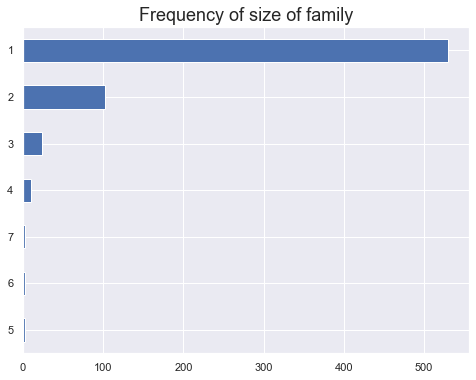

In [61]:
# Data leakage by ignoring family relationships? Familiar relationships make that observations in test set might not be independent from ones in the training set.
# Candidate for GroupKFold and GroupSplit.
sns.set()
plt.figure(figsize=(8, 6))
train_df["Family_Case_ID"].value_counts().value_counts(ascending=True).plot(kind="barh")
plt.title("Frequency of size of family", fontsize=18)
plt.show()

In [62]:
df_explore = pd.merge(train_df, train_df["Family_Case_ID"].value_counts(), right_index=True, left_on="Family_Case_ID").drop("Family_Case_ID_x", axis=1).rename({"Family_Case_ID_y": "Family_size"}, axis=1)
df_explore

,Family_Case_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased,Family_size
Patient_ID,,,,,,,,,,,
1,4696,3,Miss Linda Betty,NaN,0,0,225,NaN,Santa Fe,1,1
2,21436,1,Ms. Ramona Elvira,1966.0,0,1,1663,NaN,Albuquerque,0,1
3,7273,3,Mr. Mario Vernon,1982.0,0,0,221,NaN,Santa Fe,1,1
4,8226,3,Mr. Hector Joe,1997.0,0,0,220,NaN,Santa Fe,1,1
5,19689,3,Ms. Jennie Debra,1994.0,0,0,222,NaN,Santa Fe,0,1
...,...,...,...,...,...,...,...,...,...,...,...
894,345,2,Mr. Adam Donovan,1958.0,0,0,271,NaN,Taos,1,1
895,9846,3,Mr. Noel Mcdougall,1993.0,0,0,243,NaN,Santa Fe,1,1
897,6483,3,Mr. Haiden Vance,2006.0,0,0,258,NaN,Santa Fe,0,1


In [74]:
df_explore.groupby("Family_Case_ID").count()

,Severity,Name,Birthday_year,Parents_Children_Infected,Partner_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased,Family_size
Family_Case_ID,,,,,,,,,,
345,1,1,1,1,1,1,0,1,1,1
981,1,1,1,1,1,1,0,1,1,1
1773,1,1,1,1,1,1,0,1,1,1
1794,1,1,1,1,1,1,1,1,1,1
1816,1,1,1,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
24454,2,2,1,2,2,2,0,2,2,2
24471,1,1,1,1,1,1,0,1,1,1
24520,2,2,2,2,2,2,0,2,2,2


In [79]:
# Variable groups
lc_c_features = ["Severity", "Medical_Tent", "City"]  # low cardinality and categorical variables
metric_features = df_explore.columns.drop(lc_c_features + ["Family_Case_ID", "Name"]).to_list()  # metric variables

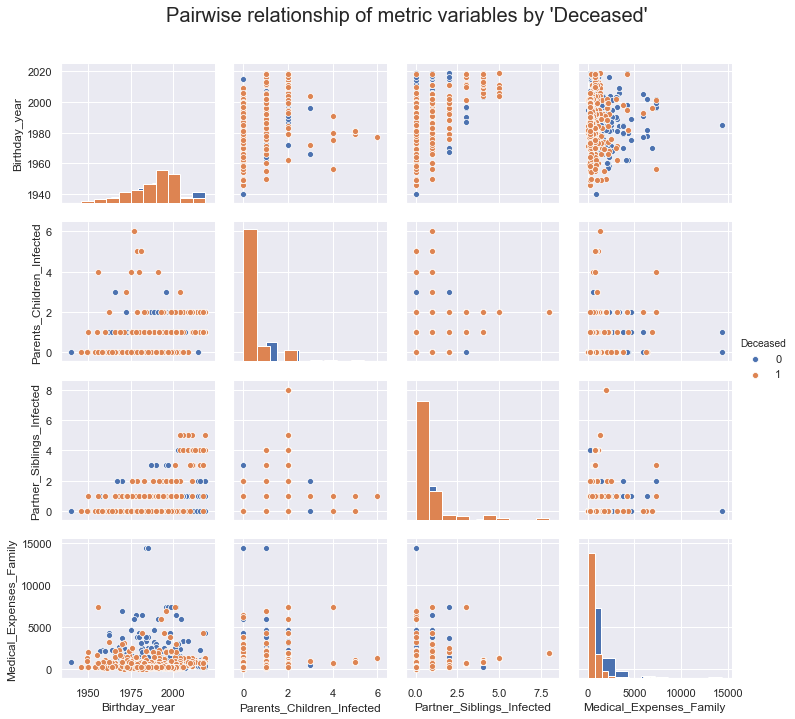

In [81]:
# data to plot
plot_df = pd.concat([df_explore[metric_features], df_explore.Deceased], axis=1)

sns.set()

# Setting pairgrid
g = sns.pairplot(plot_df, hue="Deceased", diag_kind="hist")

# Layout
plt.subplots_adjust(top=0.9)
plt.suptitle("Pairwise relationship of metric variables by 'Deceased'", fontsize=20)

plt.show()

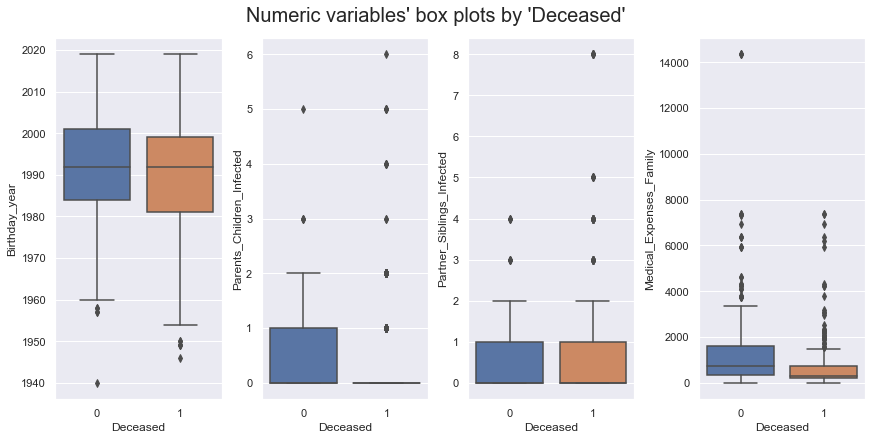

In [82]:
sns.set()

# data to plot
plot_df = pd.concat([df_explore[metric_features], df_explore.Deceased], axis=1)
plot_features = metric_features

# Prepare figure
fig, axes = plt.subplots(1, len(plot_features), figsize=(12,6), constrained_layout=True)
    
# Plot data
for ax, f in zip(axes.flatten(), plot_features):
    sns.boxplot(y=f, data=plot_df, ax=ax, x='Deceased')

# Layout
plt.suptitle("Numeric variables' box plots by 'Deceased'", fontsize=20)

plt.show()

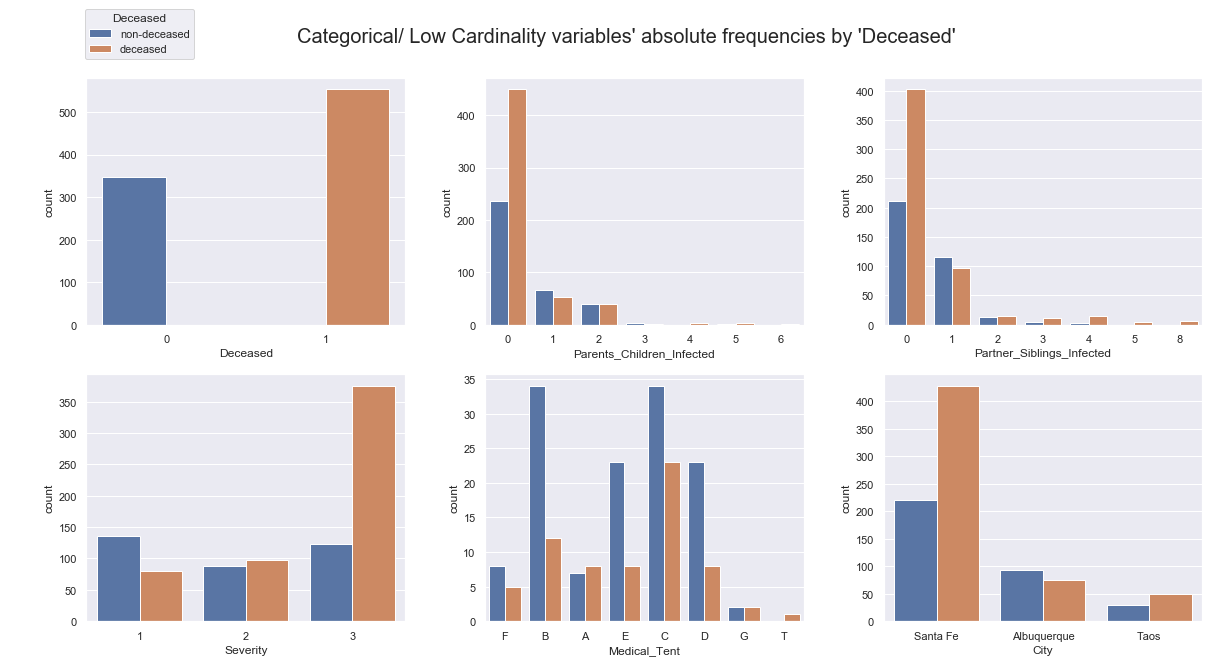

In [83]:
sns.set()

# data to plot
plot_df = pd.concat([df_explore[lc_c_features + ["Parents_Children_Infected", "Partner_Siblings_Infected"]], df_explore.Deceased], axis=1)
plot_features = ["Deceased", "Parents_Children_Infected", "Partner_Siblings_Infected"] + lc_c_features

# figure and axes
fig, axes = plt.subplots(2, ceil(len(plot_features)/2), figsize=(20,10))

# plot data
for ax, x in zip(axes.flatten(), plot_features):
    if x == "Deceased":
        sns.countplot(x=x, hue="Deceased", order=[0, 1], data=plot_df, ax=ax)
    else:
        sns.countplot(x=x, hue="Deceased", data=plot_df, ax=ax)
    ax.get_legend().remove()
    
# Set legend (IsCanceled)
handles, _ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ["non-deceased", "deceased"], loc=(0.07,0.91), title="Deceased", title_fontsize=12)

plt.subplots_adjust(wspace=0.25)
plt.suptitle("Categorical/ Low Cardinality variables' absolute frequencies by 'Deceased'", y=0.95, fontsize=20)

plt.show()

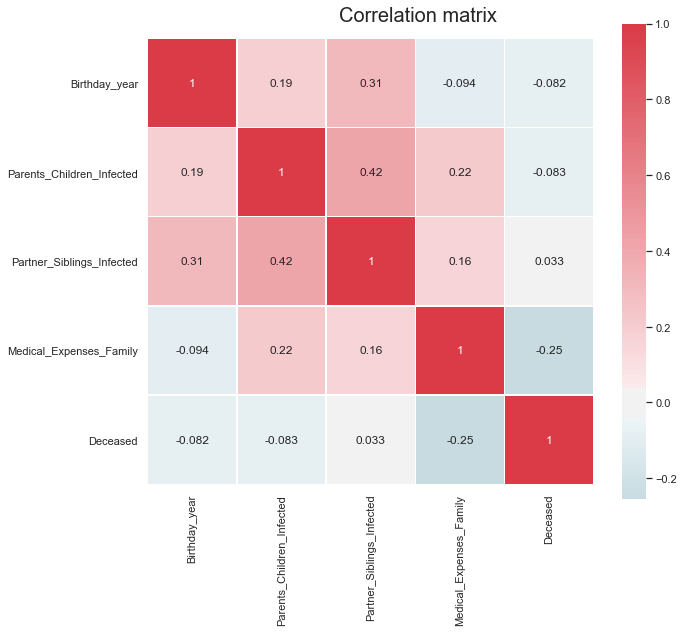

In [84]:
sns.set(style="white")

# Compute the correlation matrix
corr = pd.concat([df_explore[metric_features], df_explore.Deceased], axis=1).corr() #Getting correlation of numerical variables

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

# # Pass 2D Numpy array to annot parameter
# mask_annot = np.absolute(corr.values)>=0.50 # Annotate correlations above abs(0.5)
# annot_arr = np.where(mask_annot, corr.values.round(2), np.full(corr.shape,""))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, center=0, square=True, linewidths=.5, annot=corr, ax=ax)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Correlation matrix", fontsize=20)
plt.yticks(rotation=0)
# Fixing the bug of partially cut-off bottom and top cells
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Takeaways
- *Univariate outliters*: Medical_Expenses_Family, Parents_Children_Infected (should we keep values above 2?), Partner_Siblings_Infected (should we keep values above 2?).
- *Bivariate outliers*: There might be some by visualizing the bivariate scatter plots. Multivariate outlier detection could be applied.
- *High cardinality*: Medical_tent (there are some values with low presence)
- *Data leakage*: There is some potential for data leakage because of Family_Case_ID variable. Transform it to avoid this issue or do appropriate splits.

# Data Cleaning
In this section we will clean our data using a copy of our train data. After having decided on some preprocessing steps (e.g. missing value imputer, scalling) we will integrate them in the pipeline and tune their parameters with grid-search.

## Outliers

In [ ]:
# Visual outlier removal
# LocalOutlierFactor

## Missing Values
There are 3 variables that we have to treat regarding missing values. They are Birthday_year, Medical_Tent and City.

In [64]:
train_df.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                177
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 702
City                           2
Deceased                       0
dtype: int64

There are only 2 null values in City so we decided to replace them with the mode, Santa Fe, that stands for the city of 72% of the patients.

In [68]:
print(train_df.City.value_counts())
train_df.City = train_df.City.fillna(value="Santa Fe")

Santa Fe       651
Albuquerque    169
Taos            80
Name: City, dtype: int64


78% of the observations have no value in Medical_Tent. The first thought is dropping the variable but on a second thought, the nulls in Medical_Tent may mean that they treated the disease at home. Or maybe the tent is just not know, we would have to ask the data owner to be sure, but for now we will replace the null values for "Not Known" and then assess the variable discriminating power according to the target.

In [71]:
train_df.Medical_Tent = train_df.Medical_Tent.fillna(value="Not Known")

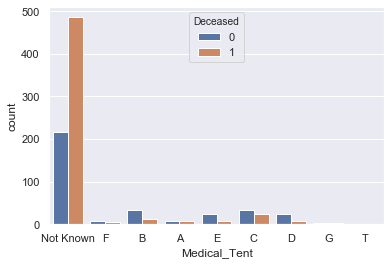

In [73]:
sns.set()
sns.countplot(x="Medical_Tent", hue="Deceased", data=train_df)
plt.show()

In [32]:
test_df.isnull().sum()

Family_Case_ID                 0
Severity                       0
Name                           0
Birthday_year                 82
Parents_Children_Infected      0
Partner_Siblings_Infected      0
Medical_Expenses_Family        0
Medical_Tent                 311
City                           0
dtype: int64

In [35]:
test_df.shape

(400, 9)

In [33]:
train_df.isna().sum(axis=1).value_counts()

1    565
0    177
2    158
dtype: int64

In [ ]:
# KNNImputer or IterativeImputer
# Impute cabin values with NK (not known) tag. too much to try to estimate. other option could be to eliminate but I would build the variable and then let the model decide.

## Feature Engineering

In [ ]:
# Solve some issues with existing features (e.g. high cardinality)
# Family_Case_ID is promissing to find out relevant familiar relationships (e.g. if some familiar died or not)
# We can analyze Name and obtain Title and Gender and Married
# Age instead of Birth_year
# Family infected (sum of parent or children and partner or siblings)

## Assessment

In [ ]:
# Assess preprocessed data using visualizations. Check if problems are solved and if features are useful

## Preprocessed data

In [ ]:
# ensure all the data (train and test) is prepared for modelling (even though we will apply some preprocessing steps in the pipeline ahead, 
#     there are some stuff we need to do previously like ensure every dataset has all the features required).

# Modelling
In this section we will build our sklearn Pipeline and use it to find out the best hyperparameters according to the model accuracy. We will also use it to select the most appropriate classifier algorithm and do model comparision.

In [ ]:
# Saving parameter grid for specific Grid Search run
class ComplexEncoder(json.JSONEncoder):  # This class is used to save the instance objects belonging to a grid as strings
    def default(self, obj):
        if isinstance(obj, (StandardScaler, MinMaxScaler, SelectFromModel, LogisticRegression, KNeighborsClassifier, GaussianNB, np.ndarray, NeighborhoodComponentsAnalysis, dict)):  # Include all classes that aren't serializable here
            return str(obj)
        # Let the base class default method raise the TypeError 
        return json.JSONEncoder.default(self, obj)
    

def gs_outputs(id_num, gscv_fitted, grid):
    """
    Function that saves information of each grid-search.
    
    id_num: takes an id_number which identifies the grid-search
    gscv_fitted: takes a fitted GridSearchCV object
    grid: takes the grid used to fit the GridSearchCV object
    
    Returns:
    top 20 configurations hyper-parameter presence graphic
    (also outputs the "logs" of each grid-search to the output directory)
    """
    
    # Saving parameter grid for specific Grid Search run
    with open("./outputs/grids.txt", "a") as file:
        file.write("# {}------------------------------------------------------ #\n".format(id_num) + json.dumps(grid, cls=ComplexEncoder) + "\n\n")

    # Saving cv_results for specific Grid Search run
    score_summary = pd.DataFrame(gscv_fitted.cv_results_).sort_values(by="mean_test_score", ascending=False)
    score_summary.to_csv("./outputs/grid_search_results{}.csv".format(id_num))
    
    # Assessing distribution of hyper-parameter values amongst top 20 models
    sns.set()

    # Features to plot
    plot_features = list(map(lambda x: "param_" + x, {i for j in range(len(grid)) for i in grid[j].keys()}))
    plot_df = score_summary.reset_index(drop=True).loc[:19, :].fillna("NaN")

    # figure and axes
    fig, axes = plt.subplots(3, ceil(len(plot_features)/3), figsize=(23,13))

    # plot data
    for ax, x in zip(axes.flatten(), plot_features):
        try:
            sns.countplot(x=x, data=plot_df, ax=ax)
        except TypeError:
            sns.countplot(x=plot_df[x].apply(json.dumps), ax=ax)

    plt.suptitle("Hyper-parameter presence on top 20 models", y=0.95, fontsize=25)

    plt.savefig("./outputs/grid_results{}.png".format(id_num))
    
    # Model training - using best parameters to train model on entire data for submission
    best_model = full_pipeline.set_params(**gscv_fitted.best_params_)
    best_model.fit(X, y)  # Using all of the data to fit the model

    # Predicting the 
    y_pred = best_model.predict(test_df)

    # Submission
    pd.DataFrame(data={"Employee_ID": test_df.index.to_list(), "Churn_risk": y_pred}).to_csv("./outputs/submission{}.csv".format(id_num), index=False)
    
    return plt.show()

In [ ]:
# Categrical features to pass down the categorical pipeline 
categorical_features = []  # COMPLETE

# Numerical features to pass down the numerical pipeline 
metric_features = X_train.columns.drop(categorical_features).to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps=[('impute_mode', SimpleImputer(strategy="most_frequent")),
                                       ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Defining the steps in the numerical pipeline     
std, minmax = StandardScaler(), MinMaxScaler()

# Combining numerical and categorical pipeline into one full big pipeline horizontally 
join_pipeline = ColumnTransformer(transformers=[('numerical_pipeline', "passthrough", metric_features),  # we will find out what's the best scaler in GS
                                                 ('categorical_pipeline', categorical_pipeline, categorical_features)])

# Imputing Missing values with normalized and one hot encoded data
imputer = KNNImputer()

# Finally, we will impute NaNs with KNNImputer and build our preprocessing pipeline
prep_pipeline = Pipeline(steps=[("join_features", join_pipeline),
                                ("imputer", imputer)])

# Feature Selection
fselect1 = SelectFromModel(LogisticRegression(penalty="l1", max_iter=400, multi_class="multinomial", solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C
fselect2 = NeighborhoodComponentsAnalysis(max_iter=25, tol=0.005, random_state=1)  # tune: n_components, tol=0.005 (it takes to long)
fselect3 = SelectFromModel(LogisticRegression(penalty="l2", max_iter=400,  multi_class="multinomial", solver="saga", n_jobs=-1, random_state=1))  # tune: estimator__C, threshold

# Model
lr = LogisticRegression(max_iter=400, multi_class="multinomial", n_jobs=-1, random_state=1)  # tune: penalty=['elasticnet'], l1_ratio=[0.2, 0.5, 0.8], C=[10.0 ** np.arange(-4, 2)], tol=[10.0 ** np.arange(-5, 0)], class_weight=['balanced', None], solver=['newton-cg', 'sag', 'saga' and 'lbfgs']

knn = KNeighborsClassifier(n_jobs=-1)  # tune: n_neighbors, weights, metric

# gnb = GaussianNB()

# Full pipeline with model
full_pipeline = Pipeline(steps=[("prep", prep_pipeline),  # 15 features outputed
                                ("fselect1", "passthrough"),
                                ("fselect2", "passthrough"),
                                ("model", "passthrough")])

grid = [  # COMPLETE
    {
        
    },
    {
        
    }
]

In [ ]:
# Instatiating GridSearch
gscv = GridSearchCV(full_pipeline, grid, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=1), scoring='f1_micro', verbose=1, n_jobs=-1)

In [ ]:
# Get ID of grid search
id_num = input("Insert GridSearch ID number: ")

# Grid Search and model training
gscv.fit(X_train, y_train)

# Obtain outputs from Grid Search
gs_outputs(id_num, gscv, grid)

In [ ]:
# Model training - using best parameters to train model on entire training set
best_params = gscv.best_params_
best_model = full_pipeline.set_params(**best_params)
best_model.fit(X_train, y_train)

# Model assessment
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print("TRAIN set F1-score(micro) is: {:.3f}\nTEST set F1-score(micro) is: {:.3f}".format(f1_score(y_train, y_train_pred, average='micro'), f1_score(y_test, y_test_pred, average='micro')))

# References
### Model selection and evaluation
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://weina.me/nested-cross-validation/
- https://chrisalbon.com/machine_learning/model_evaluation/nested_cross_validation/
- https://www.elderresearch.com/blog/nested-cross-validation
- https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection
- https://scikit-learn.org/stable/modules/cross_validation.html
- On Over-fitting in Model Selection and Subsequent Selection Bias in Performance Evaluation, Gavin C. Cawley, Nicola L. C. Talbot

### Topic here
- 